In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.preprocessing import MultiLabelBinarizer
from typing import List
import matplotlib.pyplot as plt

/home/samuel/.conda/envs/hw2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_data = pd.read_csv('dataset/train.tsv', sep='\t')
sample = pd.read_csv('dataset/sample_submission.csv')


# EDA

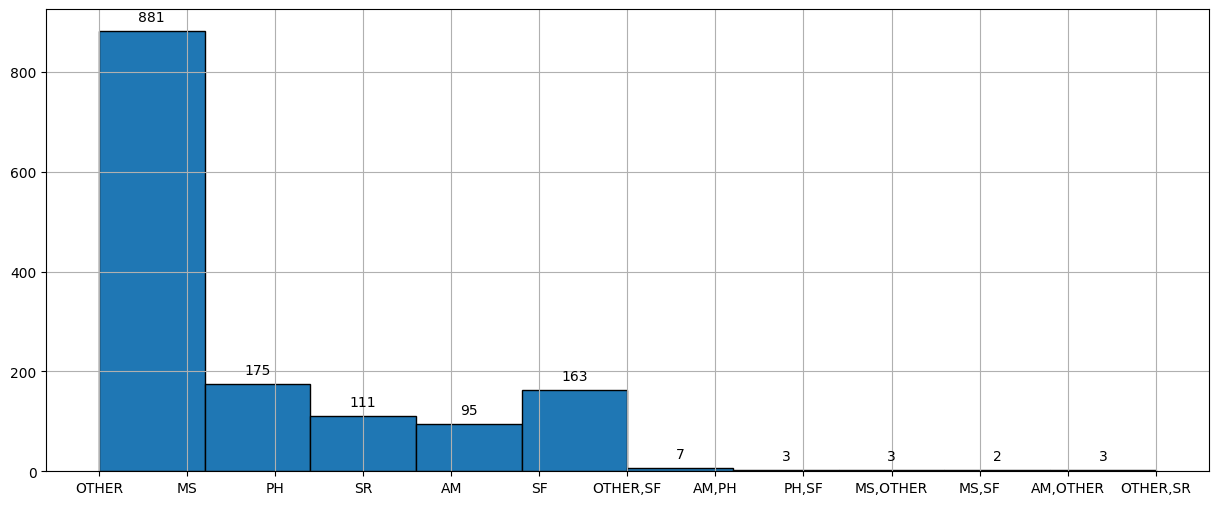

In [3]:
fig,ax =plt.subplots(figsize=(15,6))
train_data.classes.hist(ax=ax,edgecolor='black')
for rect in ax.patches:
    height = rect.get_height()
    ax.annotate(f'{int(height)}', xy=(rect.get_x()+rect.get_width()/2, height), 
                xytext=(0, 5), textcoords='offset points', ha='center', va='bottom') 

In [4]:
train_data.classes.unique(), train_data.source.nunique()

(array(['OTHER', 'MS', 'PH', 'SR', 'AM', 'SF', 'OTHER,SF', 'AM,PH',
        'PH,SF', 'MS,OTHER', 'MS,SF', 'AM,OTHER', 'OTHER,SR'], dtype=object),
 24)

In [5]:
data = train_data.utterance.apply(lambda x: len(x.split(" ")))
data.describe()

count    1443.000000
mean       10.045738
std         6.877317
min         1.000000
25%         6.000000
50%         8.000000
75%        13.000000
max       109.000000
Name: utterance, dtype: float64

In [6]:
class ConversationDataset(Dataset):
    def __init__(self, filename: str, tokenizer, max_len: int = 25, k=3, mode='train'):
        self.data = pd.read_csv(filename, sep='\t')
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.mode = mode
        self.classes_list  = pd.read_csv('dataset/sample_submission.csv').columns[1:].tolist()
        self.k = k
        if mode != "test":
            self.classes = self.data['classes'].apply(lambda x: x.split(','))
            self.mlb = MultiLabelBinarizer(classes=self.classes_list)
            self.mlb.fit(self.classes)
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        if self.mode !="train":
            utterance = self.data.iloc[idx]['utterance']
            tokens = self.tokenizer(utterance, max_length=self.max_len, padding='max_length', truncation=True)
            if self.mode == "test":
                return {
                    'input_ids': torch.tensor(tokens['input_ids'], dtype=torch.long),
                    'attention_mask': torch.tensor(tokens['attention_mask'], dtype=torch.long),
                }
            elif self.mode =="valid":
                label = self.mlb.transform([self.classes.iloc[idx]])[0]
                return {
                    'input_ids': torch.tensor(tokens['input_ids'], dtype=torch.long),
                    'attention_mask': torch.tensor(tokens['attention_mask'], dtype=torch.long),
                    'labels': torch.tensor(label, dtype=torch.float)
                }
        else: # train mode 
            if idx<2:
                utterance = self.data.iloc[idx]['utterance']
                label = self.mlb.transform([self.classes.iloc[idx]])[0]
            else:
                utterance = ' '.join([self.data.iloc[max(0, idx - i)]['utterance'] for i in range(self.k)][::-1])
                label = [self.classes.iloc[max(0, idx - i)][0] for i in range(self.k)]
                label = self.mlb.transform([label])[0]
            # print("utterance:",utterance)
            # print("original labels: ", label)
            tokens = self.tokenizer(utterance, max_length=self.max_len, padding='max_length', truncation=True)
            return {
                'input_ids': torch.tensor(tokens['input_ids'], dtype=torch.long),
                'attention_mask': torch.tensor(tokens['attention_mask'], dtype=torch.long),
                'labels': torch.tensor(label, dtype=torch.float)
            }
        
           

In [7]:
import torch.nn.functional as F
class AttentionWeightedAverage(nn.Module):
    def __init__(self, hidden_dim):
        super(AttentionWeightedAverage, self).__init__()
        self.attention = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # Compute attention weights
        attention_weights = F.softmax(self.attention(x), dim=1)
        # Weighted sum of the inputs based on attention weights
        weighted_average = torch.sum(x * attention_weights, dim=1)
        return weighted_average

class Classifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_classes, dropout=0.2):
        super(Classifier, self).__init__()
        # Pooling Layers
        self.dropout = nn.Dropout(dropout)
        self.global_max_pool = nn.AdaptiveMaxPool1d(1)
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        
        self.attention = AttentionWeightedAverage(embedding_dim)

        self.dense1 = nn.Linear(4*embedding_dim, hidden_dim)
        self.dense2 = nn.Linear(hidden_dim, num_classes)
    def forward(self, x):
        # Concatenate the pooling layers and attention
        max_pool = self.global_max_pool(x.permute(0,2,1)).squeeze(2)
        avg_pool = self.global_avg_pool(x.permute(0,2,1)).squeeze(2)
        attention_pool = self.attention(x)
        last = x[:, -1, :]
        # print(last.shape, max_pool.shape, avg_pool.shape, attention_pool.shape) #torch.Size([128, 256]) torch.Size([128, 256]) torch.Size([128, 256]) torch.Size([128, 256])
        concatenated = torch.cat([last, max_pool, avg_pool, attention_pool], dim=1)
        concatenated = self.dropout(concatenated)
        x = F.relu(self.dense1(concatenated))
        x = self.dense2(x)
        
        return x
class RoBERTaClassifier(nn.Module):
    def __init__(self, pretrained_model_name, num_classes):
        super(RoBERTaClassifier, self).__init__()
        self.roberta = AutoModel.from_pretrained(config['model_name'])
        self.classifier = Classifier(self.roberta.config.hidden_size, 384, num_classes)
        self.loss_function = nn.BCEWithLogitsLoss()
    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        roberta_embedding = outputs.last_hidden_state
        logits = self.classifier(roberta_embedding)
        if labels is not None:
            loss = self.loss_function(logits, labels)
            return {"logits": logits, "loss": loss}
        else:
            return {"logits": logits}

In [8]:
config ={
    "num_epoch":50,
    "model_name":"voidism/diffcse-roberta-base-trans", #"voidism/diffcse-roberta-base-trans"
    "batch_size": 256,
    "max_len": 70,
    "lr": 1.964e-5,
    "threshold":0.35,
    "lambda":6.17e-3,
    "k":1
}

In [9]:
# Tokenizer initialization
tokenizer = AutoTokenizer.from_pretrained(config["model_name"])
# Load and prepare dataset
train_dataset = ConversationDataset('dataset/train.tsv', tokenizer,max_len = config['max_len'],mode='train',k = config['k'])
val_dataset = ConversationDataset('dataset/val.tsv', tokenizer,max_len = config['max_len'],mode='valid')
test_dataset = ConversationDataset('dataset/test.tsv', tokenizer,max_len = config['max_len'], mode='test')

#DataLoader initialization
train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [10]:
from tqdm import tqdm
from pathlib import Path
from sklearn.metrics import f1_score

class Trainer(object):
    def __init__(self, model, opt, device, config):
        print(config)
        self.model = model
        self.device = device
        self.optimizer = opt
        self.threshold = config["threshold"]
        self.train_loss_function = nn.BCEWithLogitsLoss()
        self.test_loss_function = nn.BCEWithLogitsLoss()
        self.classes = list(pd.read_csv("./dataset/sample_submission.csv").columns[1:])
        self.lambda_ = config["lambda"]
    def train_step(self, train_dataloader):
        train_acc = 0
        train_loss = 0
        self.model.train()
        for batch in train_dataloader:
            batch = {k: v.to(self.device) for k, v in batch.items()}
            self.optimizer.zero_grad()
            outputs = self.model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'], labels=batch['labels'])
            # loss = outputs.loss
            loss = outputs["loss"]
            l2_reg = torch.tensor(0.).to(self.device)
            for param in self.model.parameters():
                l2_reg += torch.norm(param)
            loss += self.lambda_ * l2_reg
            loss.backward()
            self.optimizer.step()
            train_loss+=loss.item()
            # logits = outputs.logits
            logits = outputs["logits"]
            pred_y = (torch.sigmoid(logits)>self.threshold).int()
            pred_y = pred_y.cpu().detach().numpy()
            labels = batch['labels'].cpu().detach().numpy()
            macro_f1 = f1_score(labels, pred_y, average='macro', zero_division=0)
            train_acc += macro_f1
        return train_loss/len(train_dataloader), train_acc/len(train_dataloader)

    def val_step(self, val_dataloader): 
        test_acc = 0
        test_loss = 0
        self.model.eval()
        with torch.inference_mode():
            for batch in val_dataloader:
                batch = {k: v.to(self.device) for k, v in batch.items()}
                outputs = self.model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'], labels=batch['labels'])
                labels = batch['labels'].cpu().detach().numpy()
                # logits = outputs.logits
                logits = outputs["logits"]
                pred_y = (torch.sigmoid(logits)>self.threshold).int()
                pred_y = pred_y.cpu().detach().numpy()
                macro_f1 = f1_score(labels, pred_y, average='macro', zero_division=0)
                test_acc += macro_f1
                # test_loss += outputs.loss.item()
                test_loss += outputs["loss"].item()
        return test_loss/len(val_dataloader), test_acc/len(val_dataloader)
    def test_step(self, test_dataloader): 
        self.model.eval()
        all_data =np.zeros((len(test_dataloader),6))
        with torch.inference_mode():
            for i,batch in enumerate(test_dataloader):
                batch = {k: v.to(self.device) for k, v in batch.items()}
                logits = self.model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])["logits"]
                pred_y = (torch.sigmoid(logits)>self.threshold).int()
                pred_y = pred_y.cpu().detach().numpy()
                all_data[i] = np.expand_dims(pred_y,0)
        df =pd.DataFrame(all_data, columns= self.classes)
        return df
    def train(self, epochs, train_dataloader, val_dataloader, patience, model_name, scheduler):
        last_loss = float("inf")
        best_val_f1 =float("-inf")
        cur = 0
        results ={
            "train_loss":[],
            "train_acc":[],
            "val_loss":[],
            "val_acc":[]
        }
        for epoch in range(epochs):
            train_loss, train_acc = self.train_step(train_dataloader)
            test_loss, test_acc = self.val_step(val_dataloader)
            if scheduler:    
                scheduler.step()
            # print("lr:",scheduler.get_last_lr())
            if (epoch+1)%5 == 0:
                if test_loss > last_loss:
                    cur += 1
                    print('trigger times:', cur)
                    if cur >= patience:
                        print("early stop !")
                        return results
                else:
                    cur = 0
            last_loss = test_loss
            print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"val_loss: {test_loss:.4f} | "
            f"val_acc: {test_acc:.4f}"
            )

            results["train_loss"].append(train_loss)
            results["train_acc"].append(train_acc)
            results["val_loss"].append(test_loss)
            results["val_acc"].append(test_acc)
            
            if (epoch+1)%10 == 0:
                MODEL_PATH = Path("models/"+model_name)
                MODEL_PATH.mkdir(parents=True, 
                                exist_ok=True
                )

                MODEL_NAME = f"model_{epoch+1}.pth"
                MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
                print(f"Saving model to: {MODEL_SAVE_PATH}")
                torch.save(obj=self.model.state_dict(),
                        f=MODEL_SAVE_PATH)
            if best_val_f1<test_acc:
                best_val_f1 = test_acc
                MODEL_PATH = Path("models/"+model_name)
                MODEL_PATH.mkdir(parents=True, 
                                exist_ok=True
                )

                MODEL_NAME = f"best_model.pth"
                MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
                print(f"Saving model to: {MODEL_SAVE_PATH}")
                torch.save(obj=self.model.state_dict(),
                        f=MODEL_SAVE_PATH)
        # MODEL_PATH = Path("models/"+model_name)
        # MODEL_PATH.mkdir(parents=True, exist_ok=True)
        # # torch.save(obj=self.model.state_dict(),
        # #                 f=MODEL_PATH/f"best_model_E{epoch}.pth")
        return results

In [11]:
from optimizer import Lion
from transformers import AutoConfig, AutoModelForSequenceClassification,AutoModel
import torch.nn as nn
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model_config = AutoConfig.from_pretrained(config['model_name'])
# # model_config.num_labels = len(train_dataset.mlb.classes_)
# # model = AutoModelForSequenceClassification.from_pretrained(config["model_name"],config=model_config)
# model = AutoModelForSequenceClassification.from_pretrained(config["model_name"], num_labels=len(train_dataset.mlb.classes_))
model = RoBERTaClassifier(config["model_name"], len(train_dataset.mlb.classes_))
model.to(device)
optimizer = Lion([
    {'params': model.parameters(), 'lr': config['lr']},
    # {'params': list(model.parameters()), 'lr': config['lr']}
], lr=config["lr"])
trainer = Trainer(model, optimizer,device, config)
res = trainer.train(epochs=config['num_epoch'], train_dataloader=train_dataloader, val_dataloader=val_dataloader, patience=100, model_name="previous3_test", scheduler=None)


Some weights of the model checkpoint at voidism/diffcse-roberta-base-trans were not used when initializing RobertaModel: ['generator.roberta.encoder.layer.5.intermediate.dense.bias', 'mlp.net.1.running_mean', 'aux_bert.encoder.layer.1.attention.self.query.weight', 'aux_bert.encoder.layer.3.intermediate.dense.weight', 'aux_bert.encoder.layer.6.attention.self.key.weight', 'aux_bert.encoder.layer.2.attention.output.dense.bias', 'generator.roberta.encoder.layer.1.attention.self.key.bias', 'generator.roberta.encoder.layer.2.attention.output.dense.bias', 'aux_bert.encoder.layer.9.intermediate.dense.bias', 'generator.roberta.encoder.layer.4.attention.output.LayerNorm.weight', 'lm_head.decoder.weight', 'aux_bert.encoder.layer.10.attention.self.key.weight', 'aux_bert.encoder.layer.10.attention.output.LayerNorm.bias', 'aux_bert.encoder.layer.8.output.LayerNorm.weight', 'aux_bert.encoder.layer.8.output.dense.weight', 'generator.roberta.encoder.layer.4.output.dense.weight', 'generator.roberta.enco

{'num_epoch': 50, 'model_name': 'voidism/diffcse-roberta-base-trans', 'batch_size': 256, 'max_len': 70, 'lr': 1.964e-05, 'threshold': 0.35, 'lambda': 0.00617, 'k': 1}
Epoch: 1 | train_loss: 34.8846 | train_acc: 0.2250 | val_loss: 0.4404 | val_acc: 0.1127
Saving model to: models/previous3_test/best_model.pth
Epoch: 2 | train_loss: 34.7050 | train_acc: 0.1106 | val_loss: 0.3911 | val_acc: 0.1127
Epoch: 3 | train_loss: 34.6395 | train_acc: 0.1104 | val_loss: 0.3810 | val_acc: 0.1127
Epoch: 4 | train_loss: 34.5904 | train_acc: 0.1111 | val_loss: 0.3657 | val_acc: 0.1156
Saving model to: models/previous3_test/best_model.pth
Epoch: 5 | train_loss: 34.5366 | train_acc: 0.1268 | val_loss: 0.3505 | val_acc: 0.1733
Saving model to: models/previous3_test/best_model.pth
Epoch: 6 | train_loss: 34.4779 | train_acc: 0.1834 | val_loss: 0.3356 | val_acc: 0.3164
Saving model to: models/previous3_test/best_model.pth
Epoch: 7 | train_loss: 34.4285 | train_acc: 0.3256 | val_loss: 0.3233 | val_acc: 0.4580
S

In [12]:
trainer.model.load_state_dict(torch.load("./models/previous3_test/best_model.pth"))
trainer.model.eval()
trainer.model.to(device)
test_res = trainer.test_step(test_dataloader)
test_data = pd.read_csv('dataset/test.tsv', sep='\t')
test_res.reset_index(drop=True,inplace=True)
test_res.index = test_data.id
test_res.to_csv("./submission.csv", index_label="id")

<Axes: >

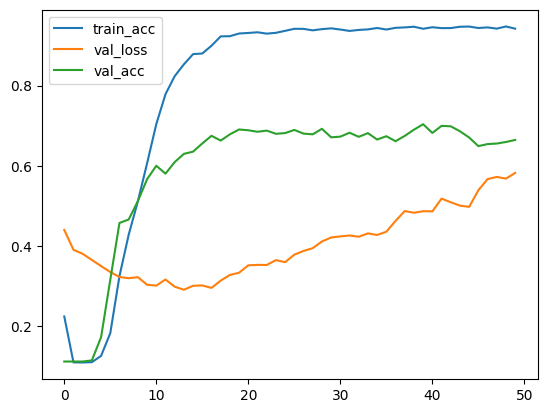

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
df = pd.DataFrame(res)
df.iloc[:,1:].plot()    

In [14]:
df['val_acc'].tolist().index(df['val_acc'].max()),df['val_acc'].max()

(39, 0.7038186985490906)